# Exploratory policy analysis

### 1. Installing EMA workbench
Run the codoes in this section to install the workbench. This includes the selected problem formulation, as well as enlisting the uncertainties, policy levers and outcomes. 

In [1]:
# importing libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from SALib.analyze import sobol

In [2]:
# Installing EMA workbench
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.em_framework.salib_samplers import get_SALib_problem


/Users/kiki/anaconda3/lib/python3.10/site-packages/ema_workbench/em_framework/evaluators.py:58: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


In [3]:
# Choose used problem formulation
## Argument: for exploratory analysis problem formulation 2 is sufficient to see the basic effects of the different policies

ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
# our objective= minimize total costs

''''
2: expected damages, dike investment costs, rfr costs, evacuation cost, and casualties (choose this)
4: Expected damages, dike investment cost and casualties disaggregated over dike rings and room for the river and evacuation costs (choose this)
'''

dike_model, planning_steps = get_model_for_problem_formulation(2)


In [4]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

# location dependent parameters
# Bmax = final breach width (absolute)
# pfail = dike failure probability
# Brate = Breach width model (relative) /day
# ID_flood wafe shape

#discount rate Multiple Decision Points: The dike_model likely involves multiple decision points or stages over time. Each discount rate parameter can correspond to a specific decision point or phase in the model. For example, discount rate 0 may be associated with immediate costs and benefits, discount rate 1 with short-term impacts, and discount rate 2 with long-term consequences. This allows for evaluating the sensitivity of decisions and outcomes to varying discount rates at different stages.

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [5]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary


# Each lever has a specific name and range of values denoted by the indexes. Let's break down the levers and their indexes: The indexes indicate the available options or levels for each lever. For example, the '0_RfR 0' lever has two options: 0 and 1. Similarly, the 'A.1_DikeIncrease 0' lever has eleven options from 0 to 10. The specific index value chosen for each lever determines the level or intensity of the intervention applied during the model simulation.
#Rfr: different project:switch on 1 off 0
#Dike_increase: different intensity in dike increase 0 to 10

for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [6]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x7fe294fe6320>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x7fe294fe6320>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x7fe294fe6320>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x7fe294fe6320>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'), function=<function sum_o

### 2. Dike heightening policies
In this section dike heightening policies are run through the model. First the policies and their levers are defined, followed by experiment runs and analysing the outputs of the policy experiments

A medium height dike increase is (5/10). A high height increase of the dikes is (10/10). For these policies, the policy intervention is initegrated on timestep 0. Experiments with other time steps follow in part 4. 

The policies which are used for experimentation in this section are:
* Policy 0: Business As Usual (BAU)
* Policy 1: All dikes have a medium height increase
* Policy 2: All dikes have a high height increase
* Policy 3: Only dike ring 1 has a medium height increase
* Policy 4: Only dike ring 2 has a medium height increase 
* Policy 5: Only dike ring 3 has a medium height increase 
* Policy 6: Only dike ring 4 has a medium height increase 
* Policy 7: Only dike ring 5 has a medium height increase 
* Policy 8: Only dike ring 1 has a high height increase 
* Policy 9: Only dike ring 2 has a high height increase 
* Policy 10: Only dike ring 3 has a high height increase 
* Policy 11: Only dike ring 4 has a high height increase 
* Policy 12: Only dike ring 5 has a high height increase 


The policies are split into 2 parts. The reason for this is to give the computer some resting time inbetween intense experiment runs. The two parts are: 
1. Policy 0 - Policy 7
2. Policy 0 + Policy 8 - 12

In [7]:
# In this cell policies 0 - 7 are created.

def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies_dikeheighteningmedium = [
    # Policy 0: BAU
    Policy(
        "P0 BAU",
        **dict(
            get_do_nothing_dict()
        )
    ),
    # Policy 1: All dikes have a medium height increase
    Policy(
        "P1 Dike Increase medium",
        **dict(get_do_nothing_dict(),
                **{'A.1_DikeIncrease 0':5,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':5,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':5,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':5,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':5,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0,
                  })
    ),
    
    # Policy 2: All dikes have a high height increase
    Policy(
        "P2 Dike Increase high",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':10,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':10,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':10,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':10,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':10,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),
    
    # Policy 3: Only Dike ring 1 has a medium height increase
    Policy(
        "P3 Dike ring 1 Increase medium",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':5,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),
    
    # Policy 4: Only Dike ring 2 has a medium height increase
    Policy(
        "P4 Dike ring 2 Increase medium",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':5,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),
    
    # Policy 5: Only Dike ring 3 has a medium height increase
    Policy(
        "P5 Dike ring 3 Increase medium",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':5,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),
    
    # Policy 6: Only Dike ring 4 has a medium height increase
    Policy(
        "P6 Dike ring 4 Increase medium",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':5,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),
    
    # Policy 7: Only Dike ring 5 has a medium height increase
    Policy(
        "P7 Dike ring 5 Increase medium",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':5,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    )  
]

The cell below runs the identified policies (cell above) using the multiprocessing evaluator of using the dike model. Each policy has 50 experiment runs, to see the varying outcomes due to the uncertainties. 

In [ ]:
# pass the policies list to EMA workbench experiment runs
n_scenarios = 50
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies_dikeheighteningmedium)

The cells below process the experiment outcomes into usable results. 

In [9]:
# define the experiments and the outcomes based on the experiment rund
experiments, outcomes = results

In [10]:
# Create dataframe of the outcomes of the experiments of policy 1-7
## Each row contains the outcomes of one experiment run. 
## This means that the first 50 rows (0 - 49) are the results of policy 0 experiments 
df_outcomes1 = pd.DataFrame(outcomes)
df_outcomes1

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,3.058266e+09,0,0.0,0.0,1.970571
1,2.437372e+08,0,0.0,0.0,0.442645
2,2.444849e+09,0,0.0,0.0,3.158145
3,2.246547e+09,0,0.0,0.0,3.216709
4,2.351721e+09,0,0.0,0.0,1.995593
...,...,...,...,...,...
395,4.654295e+09,36676675,0.0,0.0,5.477465
396,3.315645e+09,36676675,0.0,0.0,2.120311
397,1.879994e+09,36676675,0.0,0.0,1.264260
398,1.289303e+09,36676675,0.0,0.0,2.079295


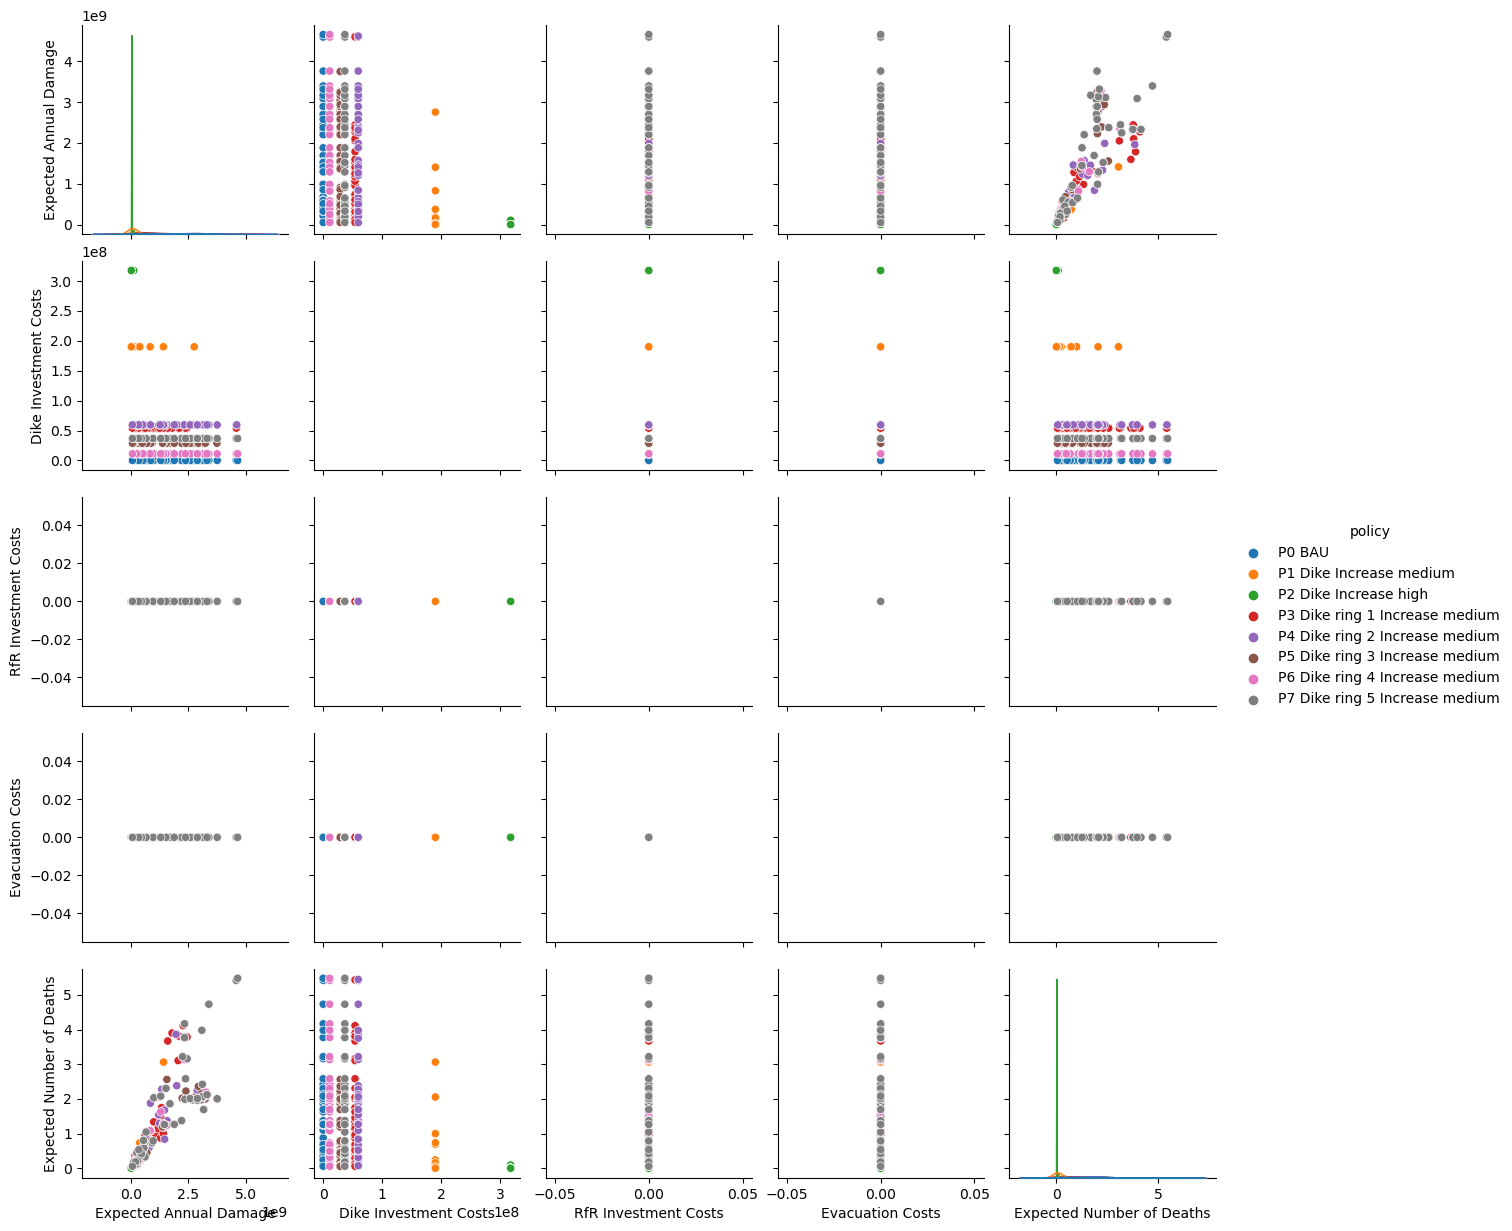

In [13]:
# This cell creates the outcomes plot where you can see how the policies score based on the outcomes
## The outcomes are based on Expected Annual Damage, Dike investment costs, RfR Investment costs, Evacuation costs and expected number of deaths
## For this analysis, evaluation costs are not used, so you dont have to look at that. 


policies_dikeheighteningmedium = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies_dikeheighteningmedium

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
fig1 = plt.gcf()
plt.show()
fig1.savefig('Medium Dike heightening policies outcome vs outcome BAU')

Interpretation outcomes graph:
* A maximal increase (10/10) of all the dikes lead to nihil deaths.
* The costs of a medium increase of the dike rings are not every different. The most expensive is DR 2, closely followed by DR 1. The least expensive is DR 4. 
* Heightening all the dikes are the most effective, but very costly. Heightening only DR 4 is cheap and results in the least EAD (expected annual damage) and END (Expected number of deaths). 

In [14]:
# This cell creates for each policy a new dataframe
## in this way, the statistics (mean) ect can be calculated per policcy
policy_dfs1 = {}
num_policies1 = 8
rows_per_policy1 = len(df_outcomes1) // num_policies1

for policy_num1 in range(1, num_policies1 + 1):
    start_index1 = (policy_num1 - 1) * rows_per_policy1
    end_index1 = policy_num1 * rows_per_policy1
    
    policy_df1 = df_outcomes1.iloc[start_index1:end_index1].copy()
    policy_dfs1[f'Policy_{policy_num1}'] = policy_df1

policy_0_df = policy_dfs1['Policy_1']
policy_1_df = policy_dfs1['Policy_2']
policy_2_df = policy_dfs1['Policy_3']
policy_3_df = policy_dfs1['Policy_4']
policy_4_df = policy_dfs1['Policy_5']
policy_5_df = policy_dfs1['Policy_6']
policy_6_df = policy_dfs1['Policy_7']
policy_7_df = policy_dfs1['Policy_8']

In [15]:
# This cell sets up the next four policies: P8 - P12
## In every policy experiment run P0 (BAU) is added to always be
## able to make a comparsion between the policies and BAU

def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies_dikeheighteninghigh = [
    # Policy 0: increase
    Policy(
        "P0 BAU",
        **dict(
            get_do_nothing_dict()
        )
    ),

    # Policy 8: Only Dike ring 1 has a high height increase
Policy(
        "P8 Dike ring 1 Increase high",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':10,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),
     # Policy 9: Only Dike ring 2 has a high height increase
    Policy(
        "P9 Dike ring 2 Increase high",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':10,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),
    
     # Policy 10: Only Dike ring 3 has a high height increase
    Policy(
        "P10 Dike ring 3 Increase high",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':10,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),
     # Policy 11: Only Dike ring 4 has a high height increase
    Policy(
        "P11 Dike ring 4 Increase high",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':10,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),
     # Policy 12: Only Dike ring 5 has a high height increase
    Policy(
        "P12 Dike ring 5 Increase high",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':10,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    )]

In [ ]:
# Run the experiments for P0 and P8-12
# pass the policies list to EMA workbench experiment runs
n_scenarios = 50
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies_dikeheighteninghigh)

In [17]:
# Save results of the experiments
experiments, outcomes = results

In [18]:
# Create dataframe with all the outcomes of P0 and P8-P12
df_outcomes2= pd.DataFrame(outcomes)
df_outcomes2

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,2.666740e+09,0,0.0,0.0,2.103364
1,2.961213e+09,0,0.0,0.0,2.021149
2,3.484131e+09,0,0.0,0.0,2.039337
3,2.114954e+09,0,0.0,0.0,2.137027
4,4.547268e+09,0,0.0,0.0,2.782740
...,...,...,...,...,...
295,1.317105e+08,58176627,0.0,0.0,0.120312
296,2.900294e+09,58176627,0.0,0.0,3.922439
297,3.094783e+09,58176627,0.0,0.0,2.000520
298,1.552533e+09,58176627,0.0,0.0,1.307657


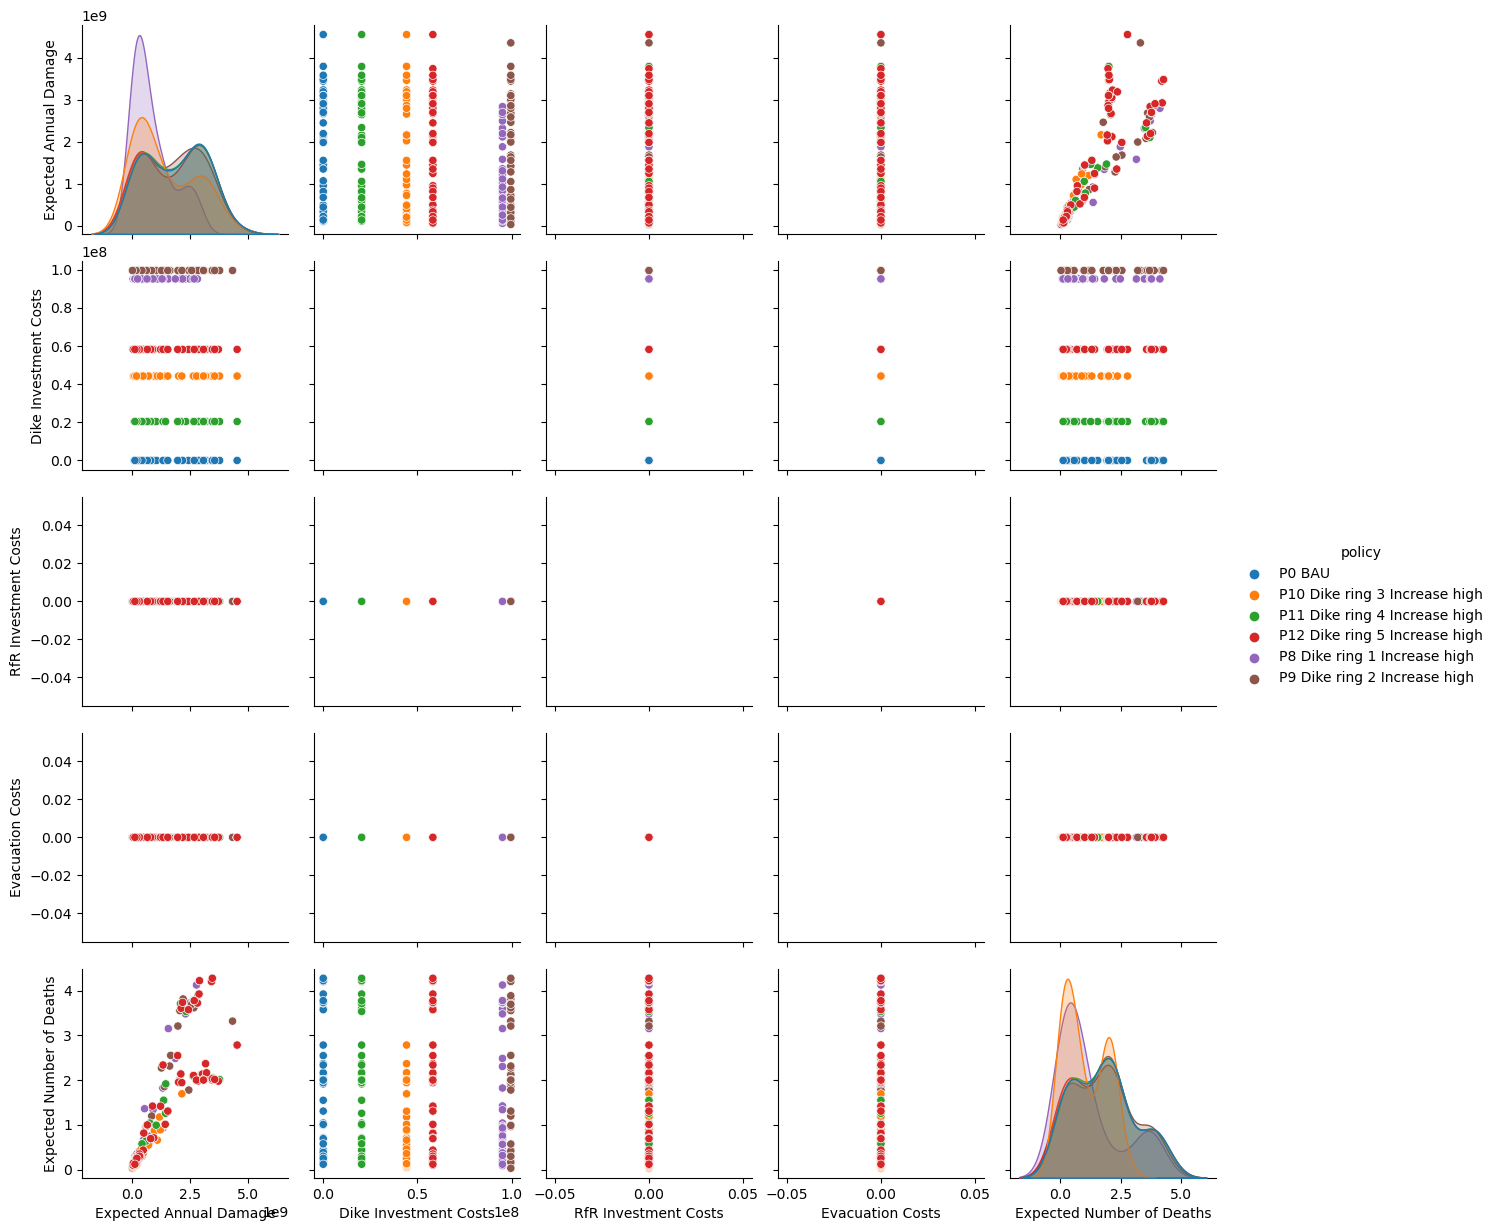

In [20]:
# Create and save outcome graph P0 + P8-P12
policies_dikeheighteninghigh = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies_dikeheighteninghigh

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
fig1 = plt.gcf()
plt.show()
fig1.savefig('High Dike heightening policies outcome vs outcome BAU')

Interpretation of outcomes graph:
* High increasement of DR 2 and DR 1 are the most expensive policies. High increasement of DR4 is the most cost reductive. 
* Eventough increasement oof DR4 is not costly, the results are more promising compared to increasement of DR 5 and DR2. This is the same for DR 3 but this is a bit more expensive. 

**Interpretation high and medium dike increasement**
* The cost difference between medium and high increasement does not seem very big
* Only increasing DR 5 medium or high leads to the most expected annual damage and deaths. Increasing only DR3 or DR4 seems the most effective agains annual damage and deaths. 
* The difference between medium or high increase of DR 5 is not big. 

In [21]:
# Create a single dataframe for outcomes of each policy experiment
policy_dfs2 = {}
num_policies2 = 6
rows_per_policy2 = len(df_outcomes2) // num_policies2

for policy_num2 in range(1, num_policies2 + 1):
    start_index2 = (policy_num2 - 1) * rows_per_policy2
    end_index2 = policy_num2 * rows_per_policy2
    
    policy_df2 = df_outcomes2.iloc[start_index2:end_index2].copy()
    policy_dfs2[f'Policy_{policy_num2}'] = policy_df2

policy_0_df = policy_dfs2['Policy_1']
policy_8_df = policy_dfs2['Policy_2']
policy_9_df = policy_dfs2['Policy_3']
policy_10_df = policy_dfs2['Policy_4']
policy_11_df = policy_dfs2['Policy_5']
policy_12_df = policy_dfs2['Policy_6']

### 3. Combination multiple dikes
In this section, experiments are run with some policies combing dike heightening on different locations. So not all at the same time, or only one at the same time. 
The policies run in this section are:
* P13: High dike heightening in Dike ring 1, Dike ring 3 and Dike ring 5. No dike heightening in Dike ring 2 and 4. 
* P14: Medium dike heightening in Dike ring 2 and dike ring 4. No dike heightening in Dike ring 1, 3 and 5. 
* P15: High dike heightening in Dike ring 1, Dike rig 3 and Dike ring 5. Medium dike heightening in Dike ring 2 and dike ring 4.

In [23]:
# In this cell P0 + P13-15 are defined. 

def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies_dikeheighteningcombination = [
    # Policy 0: Business as usual (no changes)
    Policy(
        "P0 BAU",
        **dict(
            get_do_nothing_dict()
        )
    ),

# Policy 13: High dike heightening in Dike ring 1, 3 and 5 
Policy(
        "P13 Dike ring 1,3,5 Increase high",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':10,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':10,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':10,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),

# Policy 14: Medium dike heightening in Dike ring 2 and 4
    Policy(
        "P14 Dike ring 2,4 Increase medium",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':5,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':5,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),
    
# Policy 15: High dike heightening in Dike ring 1, 3 and 5 and medium in Dike ring 2 and 4
    Policy(
        "P15 Dike ring 1,3,5 Increase high; 2,4 Increase medium",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':10,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':5,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':10,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':5,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':10,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    )]

In [ ]:
# Run policy P0 and P13-15 with 50 experiment scenarios
# pass the policies list to EMA workbench experiment runs
n_scenarios = 50
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies_dikeheighteningcombination)

In [25]:
# Save the results
experiments, outcomes = results

In [26]:
# Create dataframe of results of policy P0 - P13-15
df_outcomes3 = pd.DataFrame(outcomes)
df_outcomes3

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,2.886204e+09,0,0.0,0.0,2.001968
1,3.036855e+09,0,0.0,0.0,2.942082
2,2.442793e+09,0,0.0,0.0,3.919793
3,2.366141e+09,0,0.0,0.0,2.010704
4,3.096243e+08,0,0.0,0.0,0.434528
...,...,...,...,...,...
195,3.769417e+06,267977854,0.0,0.0,0.005290
196,1.849537e+06,267977854,0.0,0.0,0.001063
197,3.006324e+06,267977854,0.0,0.0,0.002501
198,4.317450e+06,267977854,0.0,0.0,0.002436


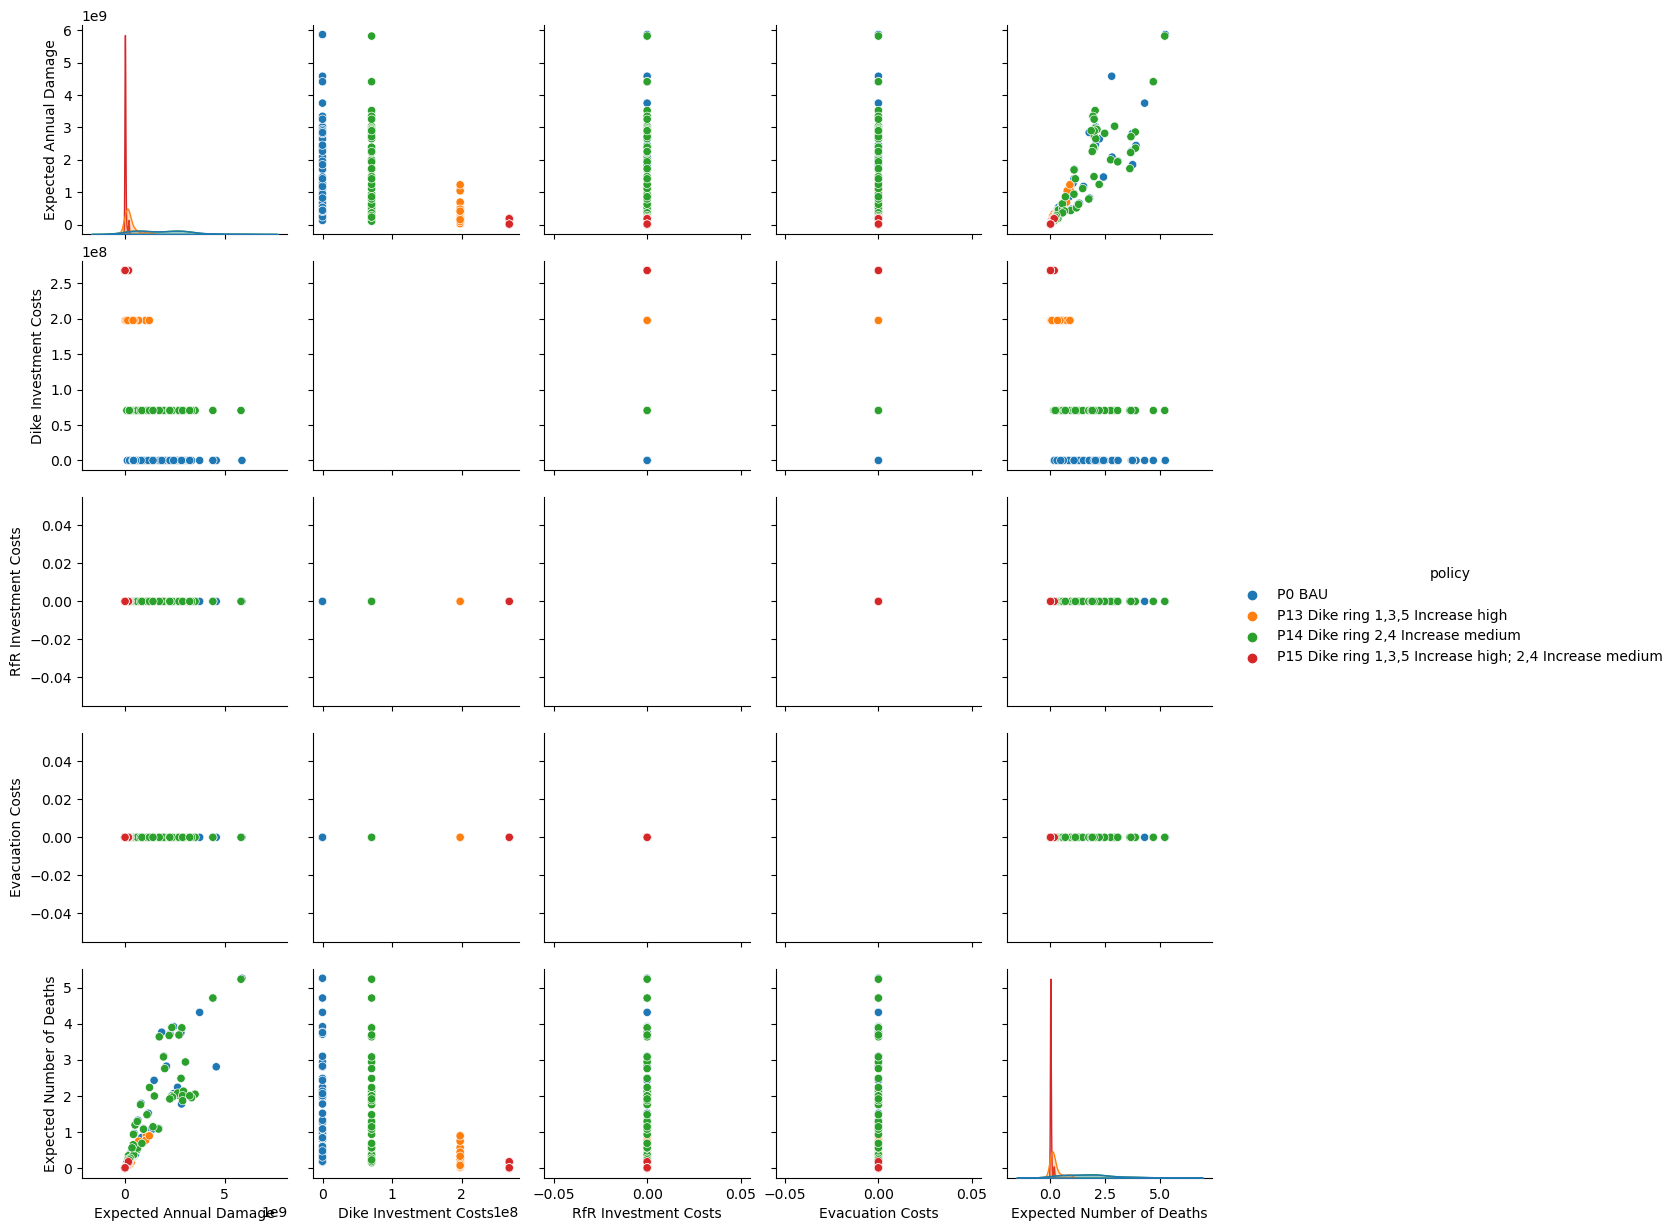

In [28]:
# Create experiment output graph for policies P0 + P13- 15
policies_dikeheighteningcombination = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies_dikeheighteningcombination

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
fig1 = plt.gcf()
plt.show()
fig1.savefig('Combination Dike heightening policies outcome vs outcome BAU')

Interpretation outcome graph:
* Only medium heightening of Dike ring 2 and 4 is not effective. 
* High heightening of Dike ring 1, 3 and 5 is very effective but costly.
* Combining high dike heightening of Dike Ring 1,3 and 5 with medium dike heightening of Dike ring 2 and 4 is very effective, but very costly. This also almost rules any death out. 

In [29]:
# Create new dataframes per policy P13-P15
policy_dfs3 = {}
num_policies3 = 4
rows_per_policy3 = len(df_outcomes3) // num_policies3

for policy_num3 in range(1, num_policies3 + 1):
    start_index3 = (policy_num3 - 1) * rows_per_policy3
    end_index3 = policy_num3 * rows_per_policy3
    
    policy_df3 = df_outcomes3.iloc[start_index3:end_index3].copy()
    policy_dfs3[f'Policy_{policy_num3}'] = policy_df3

policy_0_df = policy_dfs3['Policy_1']
policy_13_df = policy_dfs3['Policy_2']
policy_14_df = policy_dfs3['Policy_3']
policy_15_df = policy_dfs3['Policy_4']

### 4: Room for the River
In this section policies with Room for the River (RfR) are used in experiments. The policies that are tested are:
* P16: Only RfR for Dike ring 1
* P17: Only RfR for Dike ring 2
* P18: Only RfR for Dike ring 3
* P19: Only RfR for Dike ring 4
* P20: Only RfR for Dike ring 5
* P21: RfR for all Dike rings

In the first part, policy 16 - 20 are used in experiments. In the second part of this section, P21 is used. 

In [43]:
# Define policies P16 - P20
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies_rfr = [
# Policy 0: Business as Ususal
    Policy(
        "P0 BAU",
        **dict(
            get_do_nothing_dict()
        )
    ),

# Policy 16: Room for the River in Dike Ring 1
Policy(
        "P16 Dike ring 1 RfR",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':1,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),

# Policy 17: Room for the River in Dike Ring 2
    Policy(
        "P17 Dike ring 2 RfR",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':1,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),

# Policy 18: Room for the River in Dike Ring 3
    Policy(
        "P18 Dike ring 3 RfR",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':1,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),

# Policy 19: Room for the River in Dike Ring 4
    Policy(
        "P19 Dike ring 4 RfR",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':1,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),
    
# Policy 20: Room for the River in Dike Ring 5
    Policy(
        "P20 Dike ring 5 RfR",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':1,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    )
    
    ]

In [ ]:
# Run the experiument of P16 - P20
# pass the policies list to EMA workbench experiment runs
n_scenarios = 50
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies_rfr)

In [45]:
# save experiment results
experiments, outcomes = results

In [46]:
# save the results in a dataframe
df_outcomes4 = pd.DataFrame(outcomes)
df_outcomes4

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,1.103908e+09,0,0.0,0.0,1.897309
1,2.040876e+09,0,0.0,0.0,1.291769
2,1.509230e+09,0,0.0,0.0,1.366524
3,3.181083e+09,0,0.0,0.0,4.459703
4,2.214956e+09,0,0.0,0.0,2.012843
...,...,...,...,...,...
295,2.563351e+09,0,256100000.0,0.0,1.994267
296,2.421776e+09,0,256100000.0,0.0,2.003020
297,1.970595e+08,0,256100000.0,0.0,0.272782
298,2.425175e+09,0,256100000.0,0.0,3.391161


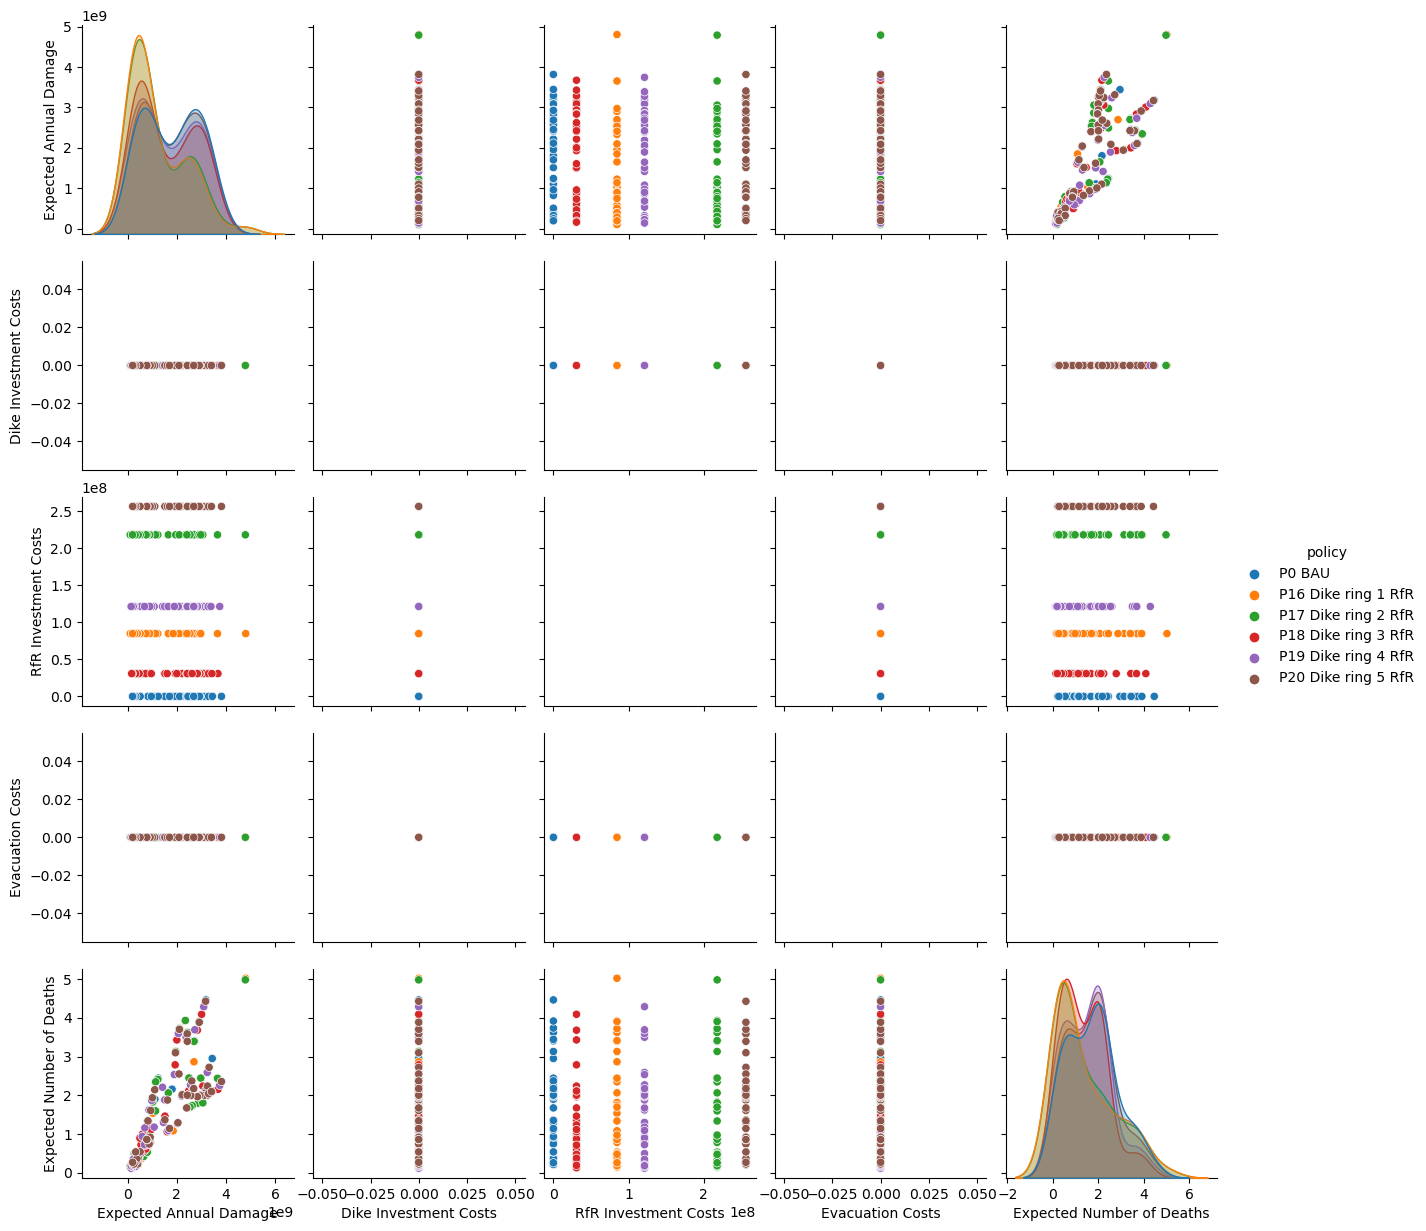

In [48]:
# Create policy outcome graph for P0 + P16-P20
policies_rfr = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies_rfr

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
fig1 = plt.gcf()
plt.show()
fig1.savefig('RfR policies outcome vs BAU experiments')

Interpretation outcome graph P0 + P16-P20:
* RfR is the most expensive for Dike ring 5 and Dike ring 2. However, these still result in one of the highest expected annual damage and number of deaths compared to the other policies. These seem not very effective.
* RfR seems the most effective for DR 1. However this is not as good as dike heightening. 
* Only applying RfR in one Dike ring, does not result in better results than P0, BAU. 

In [49]:
# Create single data frames for the experiment outcomes for each policy
policy_dfs4 = {}
num_policies4 = 6
rows_per_policy4 = len(df_outcomes4) // num_policies4

for policy_num4 in range(1, num_policies4 + 1):
    start_index4 = (policy_num4 - 1) * rows_per_policy4
    end_index4 = policy_num4 * rows_per_policy4
    
    policy_df4 = df_outcomes4.iloc[start_index4:end_index4].copy()
    policy_dfs4[f'Policy_{policy_num4}'] = policy_df4

policy_0_df = policy_dfs4['Policy_1']
policy_16_df = policy_dfs4['Policy_2']
policy_17_df = policy_dfs4['Policy_3']
policy_18_df = policy_dfs4['Policy_4']
policy_19_df = policy_dfs4['Policy_5']
policy_20_df = policy_dfs4['Policy_6']

In [51]:
# Define policy 21
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies_rfr = [
#P0: Bussiness as usual 
    Policy(
        "P0 BAU",
        **dict(
            get_do_nothing_dict()
        )
    ),
# P21: Room for the River in all Dike Rings
Policy(
        "P21 Dike rings 1,2,3,4,5 RfR",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':1,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':1,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':1,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':1,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':1,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    )
    
    ]

In [ ]:
# Run the experiments for P0 and P21
# pass the policies list to EMA workbench experiment runs
n_scenarios = 50
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies_rfr)

In [53]:
# Save experiment results of P0 and P21
experiments, outcomes = results

In [54]:
# Save results in dataframe 
# only works because we have scalar outcomes
df_outcomes5 = pd.DataFrame(outcomes)
df_outcomes5

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,6.555540e+08,0,0.0,0.0,0.585811
1,4.549957e+08,0,0.0,0.0,0.974310
2,2.170178e+08,0,0.0,0.0,0.353051
3,2.221704e+08,0,0.0,0.0,0.187894
4,1.765057e+09,0,0.0,0.0,3.761042
...,...,...,...,...,...
95,3.187111e+08,0,710400000.0,0.0,0.259798
96,1.076064e+09,0,710400000.0,0.0,1.554173
97,9.471876e+08,0,710400000.0,0.0,0.955161
98,2.707774e+09,0,710400000.0,0.0,4.016576


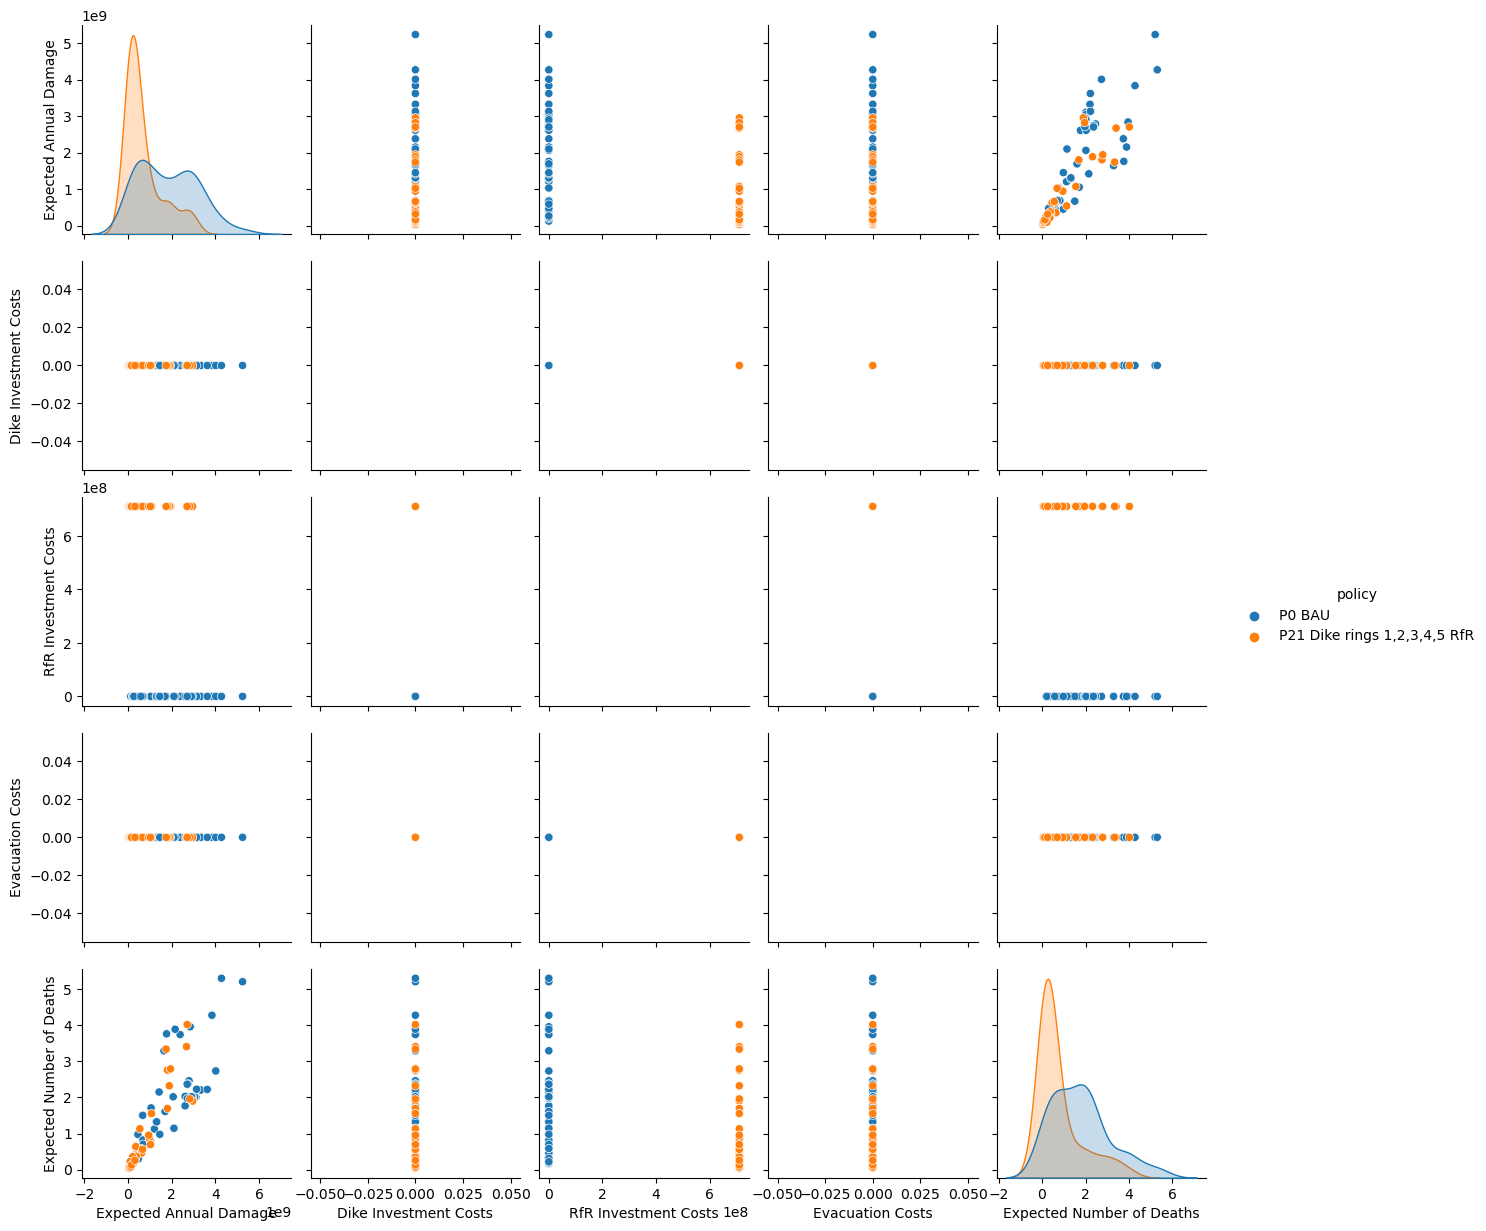

In [56]:
# Create experiment outcomes graph for P0 and P21
policies_rfr = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies_rfr

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
fig1 = plt.gcf()
plt.show()
fig1.savefig('All RfR policies outcome vs outcome first experiments')

Interpretation experiment outcome graph P0 and P21:
* Applying RfR for all dike rings is very expensiive. But results into better outcomes than P0 (BAU). However, the expected annual damage and expected number of deaths is not as dike heightening.

In [57]:
# Create single data frame for P0 and P21 with experiment results
policy_dfs5 = {}
num_policies5 = 2
rows_per_policy5 = len(df_outcomes5) // num_policies5

for policy_num5 in range(1, num_policies5 + 1):
    start_index5 = (policy_num5 - 1) * rows_per_policy5
    end_index5 = policy_num5 * rows_per_policy5
    
    policy_df5 = df_outcomes5.iloc[start_index5:end_index5].copy()
    policy_dfs5[f'Policy_{policy_num5}'] = policy_df5

policy_0_df = policy_dfs5['Policy_1']
policy_21_df = policy_dfs5['Policy_2']

### 5. Policies with different time steps
In this section, we experiment with different time steps to implement the policy interventions. 
There are three time steps: 0, 1, and 2. 

The policies that are defined for this section are:
* P22: Medium dike heightening for all Dike rings during timestep 1
* P23: High dike heightening for all Dike rings during timestep 1
* P24: Medium dike heightening for all Dike rings during timestep 2
* P25: High dike heightening for all Dike rings during timestep 2
* P26: Room for the River for all dikee rings during timestep 1
* P27: Room for the River for all dikee rings during timestep 1

This section is splitted into two experiments: one for the dike heightening and one for the Room for the River. 

In [66]:
# Define policies P22 - P25
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies_timesteps = [
# P0: Business as Usual
    Policy(
        "P0 BAU",
        **dict(
            get_do_nothing_dict()
        )
    ),

# P22: Medium dike heightening for all dike rings during timestep 1
Policy(
        "P22 Dike heightening medium (timestep 1)",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':5,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':5,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':5,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':5,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':5,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),

# P23: High dike heightening for all dike rings during timestep 1
Policy(
        "P23 Dike heightening high (timestep 1)",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':10,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':10,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':10,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':10,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':10,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),    

# P24: Medium dike heightening for all Dike rings during timestep 2
Policy(
        "P24 Dike heightening medium (timestep 2)",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':5,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':5,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':5,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':5,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':5,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),

# P25: High dike heightening for all Dike rings during timestep 2
    Policy(
        "P25 Dike heightening high (timestep 2)",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':10,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':10,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':10,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':10,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':10,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),
    
    ]

In [ ]:
# Run experiments for P22-P25
# pass the policies list to EMA workbench experiment runs
n_scenarios = 50
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies_timesteps)

In [68]:
# Save experiment outcomes as results
experiments, outcomes = results

In [69]:
# Save experiment outcomes in a dataframe
df_outcomes6 = pd.DataFrame(outcomes)
df_outcomes6

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,2.149077e+08,0,0.0,0.0,0.204071
1,2.951290e+09,0,0.0,0.0,3.754479
2,4.751360e+09,0,0.0,0.0,4.641015
3,2.184846e+08,0,0.0,0.0,0.313515
4,2.076623e+09,0,0.0,0.0,2.658592
...,...,...,...,...,...
245,1.272532e+08,317408714,0.0,0.0,0.098582
246,1.856548e+09,317408714,0.0,0.0,1.308571
247,2.892743e+09,317408714,0.0,0.0,3.194853
248,5.875363e+08,317408714,0.0,0.0,0.915623


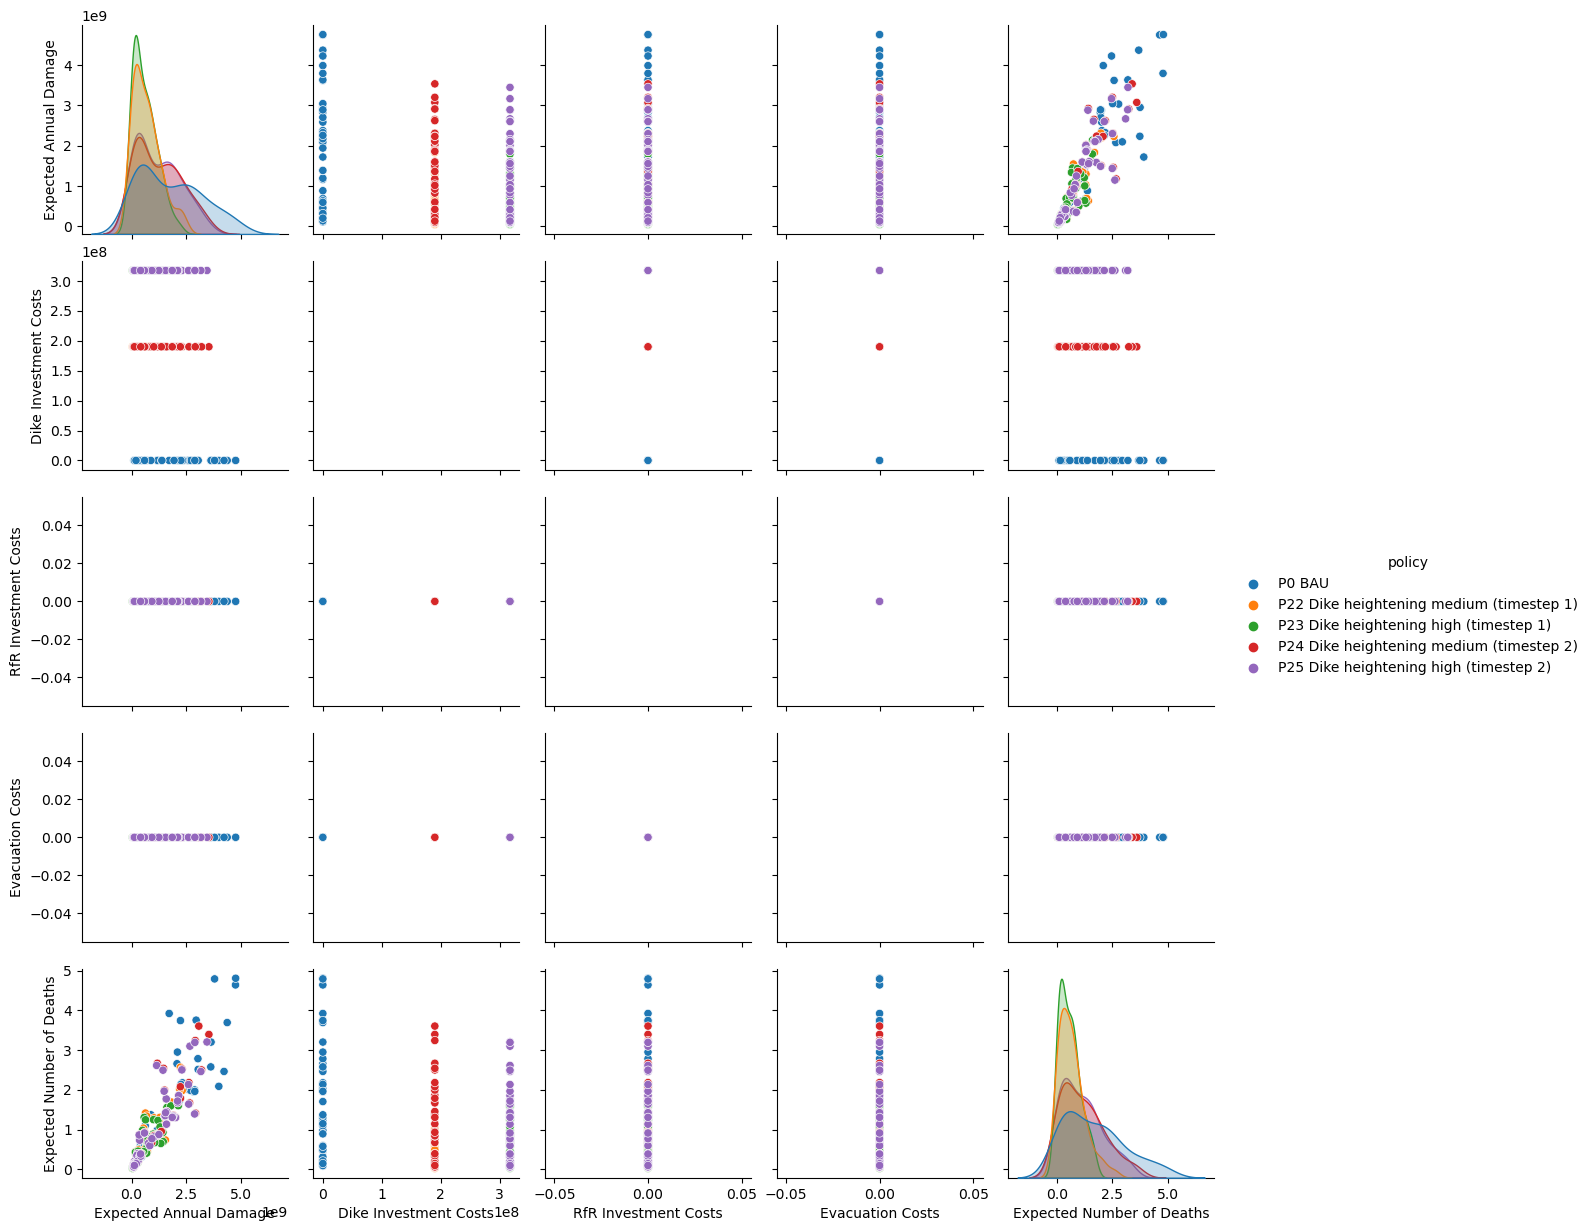

In [71]:
# Create policy outcome graph for P0 and P22 - p25
policies_timesteps = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies_timesteps

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
fig1 = plt.gcf()
plt.show()
fig1.savefig('Dike heightening medium and heigh in different time steps')

Interpretation outcome graph P22 - P26:
* The costs for dike heightening do not change when applying it in a later timestep. 
* Dike heighteninig is expected to prevent more damage and possible deaths when applied sooner. 
* Regardless of the timestep, applying dike heightening is always better than doing nothing (P0 BUA). 

**Interpretation outcome graph P22-26 and P1-2:**
* Applying medium dike heightening in a later timestep is expected to result in more deaths and damage. Even more for timestep 2 then timestep 1. 
* The costs of medium dike heightening is independent of the time. 
* Same can be applied to high dike heightening. 

In [72]:
# Create single dataframes for each policy with results
policy_dfs6 = {}
num_policies6 = 5
rows_per_policy6 = len(df_outcomes6) // num_policies6

for policy_num6 in range(1, num_policies6 + 1):
    start_index6 = (policy_num6 - 1) * rows_per_policy6
    end_index6 = policy_num6 * rows_per_policy6
    
    policy_df6 = df_outcomes6.iloc[start_index6:end_index6].copy()
    policy_dfs6[f'Policy_{policy_num6}'] = policy_df6

policy_0_df = policy_dfs6['Policy_1']
policy_22_df = policy_dfs6['Policy_2']
policy_23_df = policy_dfs6['Policy_3']
policy_24_df = policy_dfs6['Policy_4']
policy_25_df = policy_dfs6['Policy_5']

In [8]:
# Define P26 and P27
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies_rfrtimesteps = [
    Policy(
        "P0 BAU",
        **dict(
            get_do_nothing_dict()
        )
    ),

# P26: Room for River in all dike dings during timestep 1
Policy(
        "P26 Room for River (timestep 1)",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':1,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':1,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':1,
                  '2_RfR 2':0,
                  '3_RfR 0':0,
                  '3_RfR 1':1,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':1,
                  '4_RfR 2':0
             })
    ),
    
# P27: Room for River in all dike dings during timestep 2
Policy(
        "P27 Room for River (timestep 2)",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':0,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':0,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':0,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':0,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':1,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':1,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':1,
                  '3_RfR 0':0,
                  '3_RfR 1':0,
                  '3_RfR 2':1,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':1
             })
    ),    
    
    ]

In [ ]:
# Runn the experiments
# pass the policies list to EMA workbench experiment runs
n_scenarios = 50
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,  policies_rfrtimesteps)

In [10]:
# Save the experiment outcomes as results
experiments, outcomes = results

In [11]:
# Create dataframe with experiment outcomes
df_outcomes7 = pd.DataFrame(outcomes)
df_outcomes7

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,7.339923e+08,0,0.0,0.0,0.671662
1,2.295337e+09,0,0.0,0.0,1.537465
2,1.051289e+09,0,0.0,0.0,1.389943
3,6.046256e+08,0,0.0,0.0,0.660232
4,1.133178e+09,0,0.0,0.0,2.281417
...,...,...,...,...,...
145,6.054493e+08,0,710400000.0,0.0,0.468725
146,8.043043e+07,0,710400000.0,0.0,0.093203
147,2.382248e+06,0,710400000.0,0.0,0.002860
148,1.829054e+08,0,710400000.0,0.0,0.145981


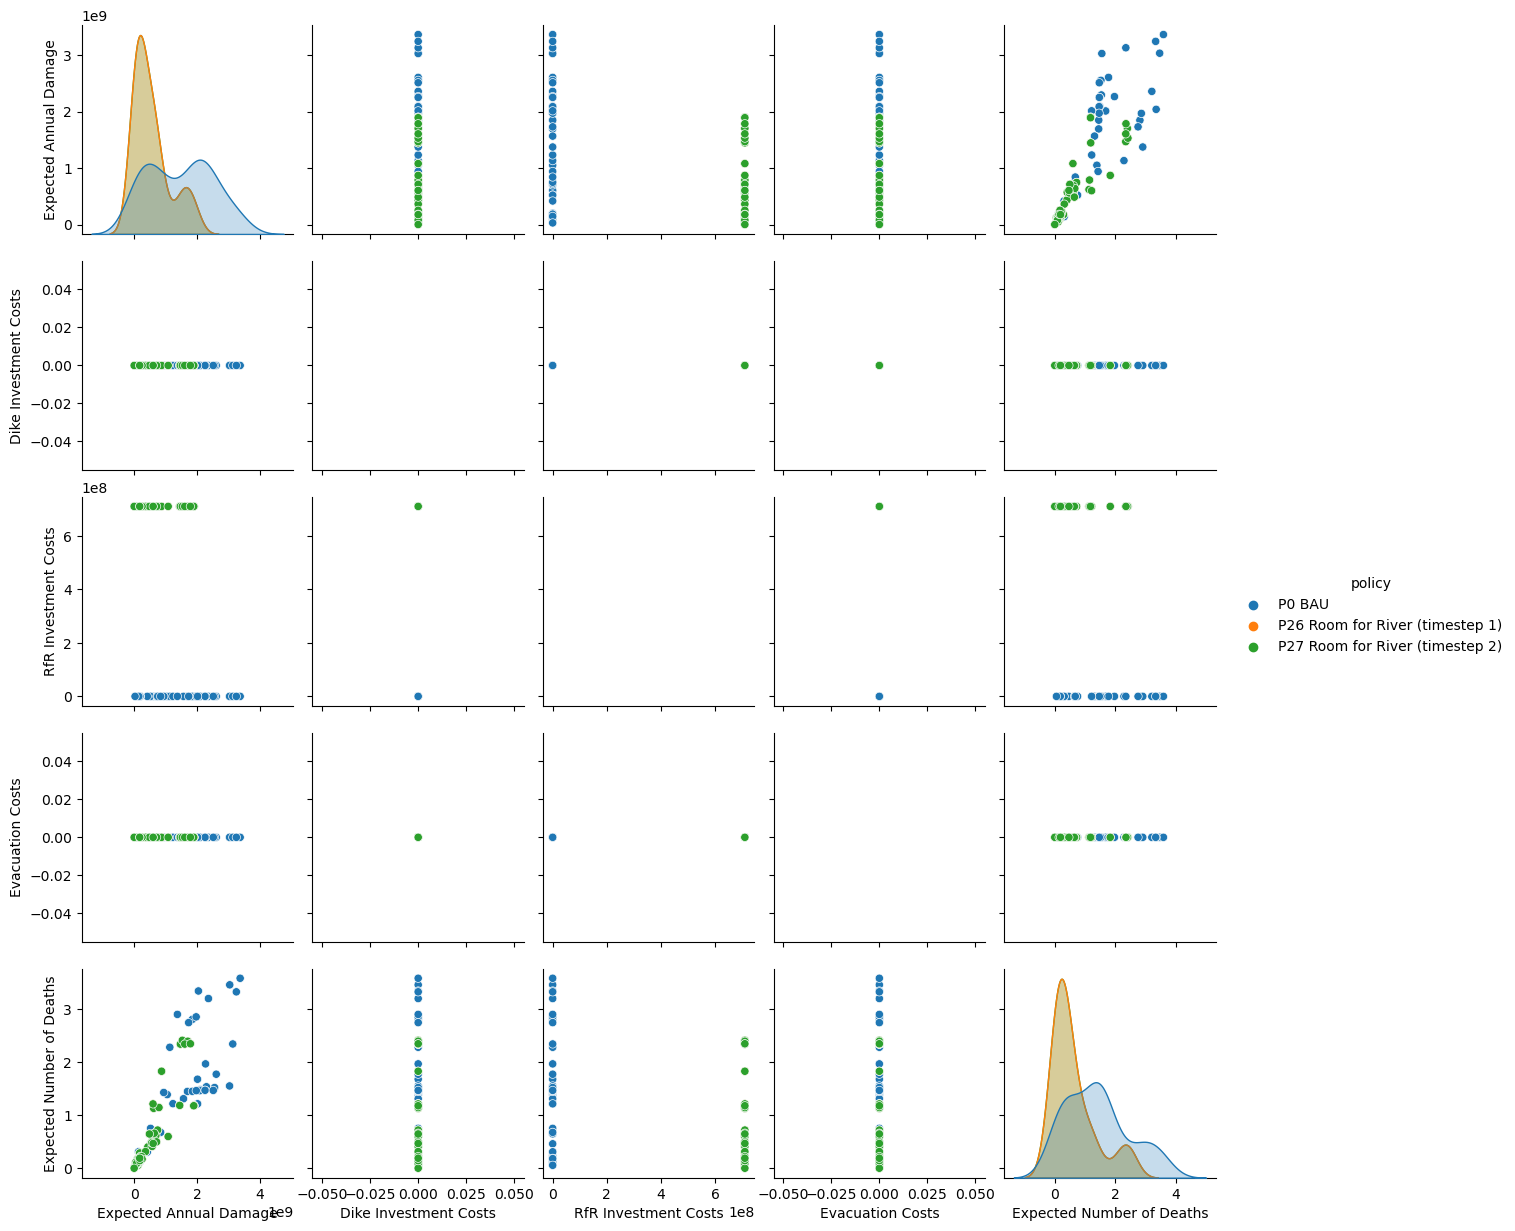

In [13]:
# Create experiment outcomes graph for P0 and P26-27
policies_rfrtimesteps = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies_rfrtimesteps

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
fig1 = plt.gcf()
plt.show()
fig1.savefig('Room for river in different time steps')

Interpretation outcome graph P26-P27:
* The costs for RfR stay consistent regardless of the time steps in which the policy is applied. 
* It is expected that the EAD and number of deaths are limited when applied sooner. Also regardless of the time step, it is better to apply RfR then doing nothing. 

**interpretation otcome graph P26-27 & P21 (timestep 0)**
* EAD is lower when applied in timestep 1 or 2 instead of timestep 0. This is an interesting result. Not what you expect. Might be caused due to 'only' 50 scenarios. 
* Same for the expected number of deaths. 

In [24]:
# Save experiment outcomes per policy in new dataframe
policy_dfs7 = {}
num_policies7 = 3
rows_per_policy7 = len(df_outcomes7) // num_policies7

for policy_num7 in range(1, num_policies7 + 1):
    start_index7 = (policy_num7 - 1) * rows_per_policy7
    end_index7 = policy_num7 * rows_per_policy7
    
    policy_df7 = df_outcomes7.iloc[start_index7:end_index7].copy()
    policy_dfs7[f'Policy_{policy_num7}'] = policy_df7

policy_0_df = policy_dfs7['Policy_1']
policy_26_df = policy_dfs7['Policy_2']
policy_27_df = policy_dfs7['Policy_3']

### 5. Create descriptives and save dataframes
In this sections the statistics per policy experiment are calculated and saved as png. In the statistics the count, mean, standard deviation, minimum value, 25%, 50% and 75% and the maximum value can be read. 

In [83]:
## Create for every policy data frame a statistics dataframe
# Define a list to store the descriptive dataframes
descriptive_dfs = []

# Iterate over the 28 policy numbers
for policy_num in range(28):
    
    # Get the policy DataFrame
    policy_df_name = f'policy_{policy_num}_df'
    # Access the dataframe dynamically
    policy_df = globals()[policy_df_name]  
    
    # Create the descriptive DataFrame
    descriptive_df = policy_df.describe()
    
    # Add the descriptive DataFrame to the list
    descriptive_dfs.append(descriptive_df)

In [84]:
## Save the descriptive dataframe per policy and place in separate folder
import os
import matplotlib.pyplot as plt

# Create the subfolder if it doesn't exist
subfolder = 'df_outcomes_policies'
if not os.path.exists(subfolder):
    os.makedirs(subfolder)

# Iterate over the descriptive DataFrames and save each as a PNG image
for policy_num, descriptive_df in enumerate(descriptive_dfs):
    # Create a plot of the DataFrame
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    tbl = ax.table(cellText=descriptive_df.values,
                   colLabels=descriptive_df.columns,
                   cellLoc='center',
                   loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.2, 1.2)

    # Save the plot as a PNG image in the subfolder
    filename = os.path.join(subfolder, f'policy_{policy_num}_descriptive.png')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)

    # Close the plot
    plt.close()

# Show a message when all images are saved
print("All descriptive DataFrames saved as PNG images.")


All descriptive DataFrames saved as PNG images.


### 6. Specific policy testing
In this section we test multiple policies based on specific information from the debate. 
The policies that are explored here are:
* P28: Medium dike heightening for dike ring 1, 2, 3 and 5 combined with Room for the River for Dike Ring 4
* P29: Medium dike heightening for dike ring 1, 2, 3 and 5 combined with Room for the River for Dike Ring 4
* P30: Medium dike heightening for dike ring 2, high dike heightening for dike ring 1, 3 and 5 combined with RfR for Dike ring 4

In [9]:
# Define policies P28 - P30
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies_specific = [
# P0: Business as Usual
    Policy(
        "P0 BAU",
        **dict(
            get_do_nothing_dict()
        )
    ),

# P28: Medium dike heightening for dike ring 1,2,3 and 5 and RfR for dike ring 4
Policy(
        "P28 Medium dike heightening DR1235; RfR DR4",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':5,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':5,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':5,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':5,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':1,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),

# P29: High dike heightening for dike ring 1,2,3 and 5 and RfR for dike ring 4
Policy(
        "P29 High dike heightening DR1235; RfR DR4",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':10,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':10,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':10,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':10,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':1,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    ),    

#P30: Medium dike heightening for dike ring 2, High dike heightening for dike ring 1,,3 and 5 and RfR for dike ring 4
Policy(
        "P30 Medium DR2; High DR135; RfR DR4",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':10,
                  'A.1_DikeIncrease 1':0,
                  'A.1_DikeIncrease 2':0,
                  'A.2_DikeIncrease 0':5,
                  'A.2_DikeIncrease 1':0,
                  'A.2_DikeIncrease 2':0,
                  'A.3_DikeIncrease 0':10,
                  'A.3_DikeIncrease 1':0,
                  'A.3_DikeIncrease 2':0,
                  'A.4_DikeIncrease 0':0,
                  'A.4_DikeIncrease 1':0,
                  'A.4_DikeIncrease 2':0,
                  'A.5_DikeIncrease 0':10,
                  'A.5_DikeIncrease 1':0,
                  'A.5_DikeIncrease 2':0,
                  '0_RfR 0':0,
                  '0_RfR 1':0,
                  '0_RfR 2':0,
                  '1_RfR 0':0,
                  '1_RfR 1':0,
                  '1_RfR 2':0,
                  '2_RfR 0':0,
                  '2_RfR 1':0,
                  '2_RfR 2':0,
                  '3_RfR 0':1,
                  '3_RfR 1':0,
                  '3_RfR 2':0,
                  '4_RfR 0':0,
                  '4_RfR 1':0,
                  '4_RfR 2':0
             })
    )
    
    ]

In [ ]:
# Run experiments for P22-P25
# pass the policies list to EMA workbench experiment runs
n_scenarios = 50
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies_specific)

In [11]:
# Save experiment outcomes as results
experiments, outcomes = results

In [12]:
# Save experiment outcomes in a dataframe
df_outcomes8 = pd.DataFrame(outcomes)
df_outcomes8

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,3.215756e+09,0,0.0,0.0,1.814545
1,2.328932e+09,0,0.0,0.0,1.842298
2,9.610499e+08,0,0.0,0.0,0.866894
3,2.440851e+09,0,0.0,0.0,1.788566
4,2.100066e+09,0,0.0,0.0,1.781898
...,...,...,...,...,...
195,8.252443e+07,256909082,121200000.0,0.0,0.074993
196,3.186444e+07,256909082,121200000.0,0.0,0.022096
197,1.247803e+07,256909082,121200000.0,0.0,0.006770
198,1.496448e+06,256909082,121200000.0,0.0,0.001086


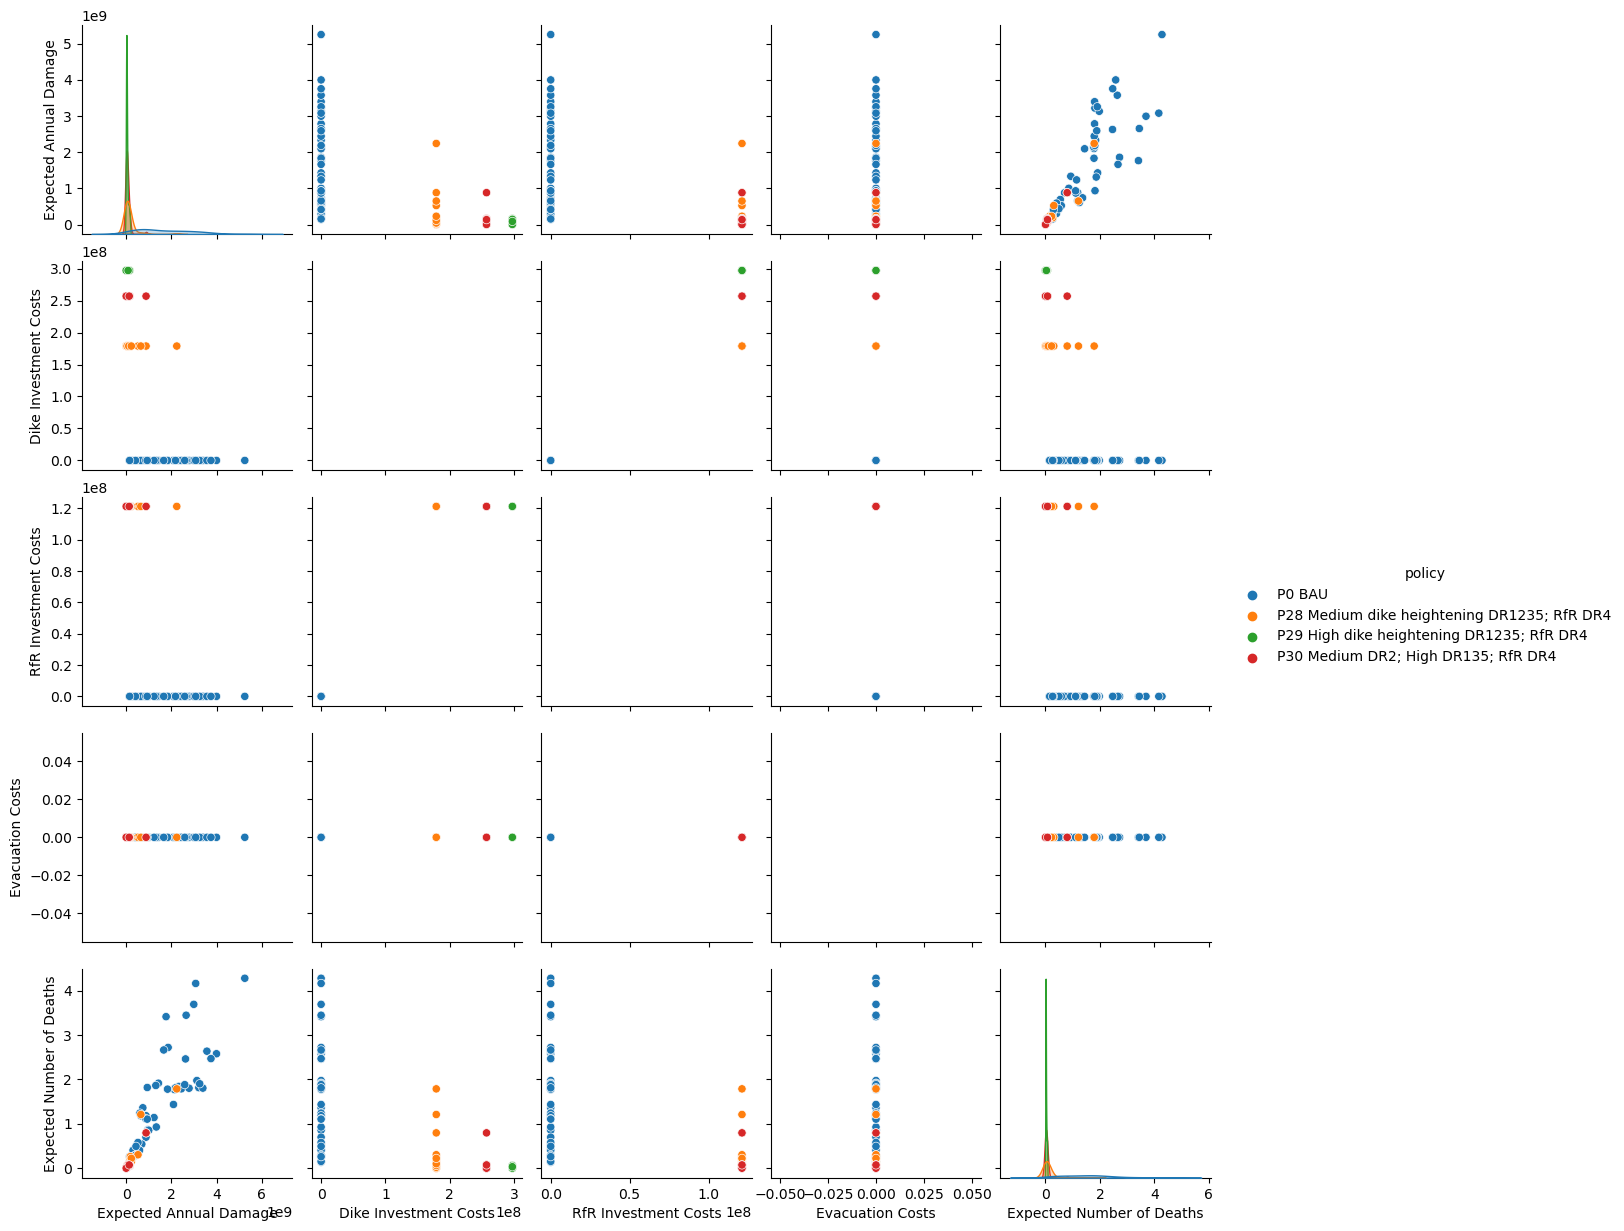

In [14]:
# Create policy outcome graph for P0 and P22 - p25
policies_specific = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies_specific

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
fig1 = plt.gcf()
plt.show()
fig1.savefig('Specific policies from Debat vs BAU')

Interpretation outcome graph P28 - P30:
* Increasing dikes from medium to high for Dike rings 1,3,5 results in less number of deaths and expected annual damage
* Medium or high dike heightening for dike ring 2 does does not make a difference as medium heightening for DR2 results in a more effective policy from 50 scenario's. 


In [16]:
# Create single dataframes for each policy with results
policy_dfs8 = {}
num_policies8 = 4
rows_per_policy8 = len(df_outcomes8) // num_policies8

for policy_num8 in range(1, num_policies8 + 1):
    start_index8 = (policy_num8 - 1) * rows_per_policy8
    end_index8 = policy_num8 * rows_per_policy8

    policy_df8 = df_outcomes8.iloc[start_index8:end_index8].copy()
    policy_dfs8[f'Policy_{policy_num8}'] = policy_df8

policy_0_df = policy_dfs8['Policy_1']
policy_28_df = policy_dfs8['Policy_2']
policy_29_df = policy_dfs8['Policy_3']
policy_30_df = policy_dfs8['Policy_4']

In [18]:
policy_30_df.describe()

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
count,5.000000e+01,50.0,50.0,50.0,50.000000
mean,5.780335e+07,256909082.0,121200000.0,0.0,0.037740
std,1.275793e+08,0.0,0.0,0.0,0.111926
min,7.333305e+05,256909082.0,121200000.0,0.0,0.000512
25%,5.681017e+06,256909082.0,121200000.0,0.0,0.003342
50%,2.022163e+07,256909082.0,121200000.0,0.0,0.015495
75%,5.582352e+07,256909082.0,121200000.0,0.0,0.036919
max,8.808345e+08,256909082.0,121200000.0,0.0,0.796634


In [27]:
## Create for every policy data frame a statistics dataframe
# Define a list to store the descriptive dataframes
descriptive_dfs = []

# Iterate over the 28 policy numbers
for policy_num in range(28,31):
    
    # Get the policy DataFrame
    policy_df_name = f'policy_{policy_num}_df'
    # Access the dataframe dynamically
    policy_df = globals()[policy_df_name]  
    
    # Create the descriptive DataFrame
    descriptive_df = policy_df.describe()
    
    # Add the descriptive DataFrame to the list
    descriptive_dfs.append(descriptive_df)

In [28]:
import os
import matplotlib.pyplot as plt

# Create the subfolder if it doesn't exist
subfolder = 'df_outcomes_policies'
if not os.path.exists(subfolder):
    os.makedirs(subfolder)

# Iterate over the policy numbers 28, 29, and 30
for policy_num in range(28, 31):
    # Get the corresponding descriptive DataFrame
    descriptive_df = descriptive_dfs[policy_num - 28]

    # Create a plot of the DataFrame
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    tbl = ax.table(cellText=descriptive_df.values,
                   colLabels=descriptive_df.columns,
                   cellLoc='center',
                   loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.2, 1.2)

    # Save the plot as a PNG image in the subfolder
    filename = os.path.join(subfolder, f'policy_{policy_num}_descriptive.png')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)

    # Close the plot
    plt.close()

# Show a message when all
